In [1]:
import ee
import os
import random
import geemap
ee.Authenticate()
ee.Initialize(project = 'tony-1122')
print(ee.String('Hello from the Earth Engine servers!').getInfo())

Hello from the Earth Engine servers!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
sample = ee.FeatureCollection('projects/tony-1122/assets/TTU/cotton/cotton_dataset_balance')
sample = ee.data.computeFeatures({
    'expression': sample,
    'fileFormat': 'PANDAS_DATAFRAME'
})

In [4]:
df = sample.iloc[:, 1:-1]
df.head()

,EVI,EVI_p20,EVI_p80,IBI,IBI_p20,IBI_p20_1,ND_blue_green,ND_blue_nir,ND_blue_p20_green_p20,ND_blue_p20_nir_p20,...,red_p80,seasonality,slope,swir1,swir1_p20,swir1_p80,swir2,swir2_p20,swir2_p80,transition
0,0.502492,0.602376,0.687418,0.074117,0.022132,0.022132,-0.041583,-0.261017,-0.046311,-0.224607,...,1.109314,0,2,1.9763,1.398000,1.897380,1.48705,1.090717,1.487333,10
1,0.741118,0.660443,0.676341,-0.008686,0.008613,0.008613,-0.029739,-0.258167,-0.051012,-0.240535,...,1.130400,0,6,1.4843,1.403450,1.904200,1.16550,1.103500,1.505667,10
2,0.514058,0.621734,0.691443,0.072008,0.023714,0.023714,-0.049119,-0.242505,-0.049895,-0.236176,...,1.125150,0,8,1.8066,1.446517,1.892675,1.52975,1.122700,1.494875,10
3,0.754902,0.619685,0.682292,0.016486,0.017687,0.017687,-0.038568,-0.244752,-0.052296,-0.236346,...,1.126650,1,7,1.5525,1.423200,1.903100,1.12830,1.115000,1.505100,5
4,0.462925,0.619685,0.682292,0.083867,0.017687,0.017687,-0.042501,-0.257184,-0.052296,-0.236346,...,1.126650,1,7,2.0097,1.423200,1.903100,1.54375,1.115000,1.505100,5


##**1DCNN**

In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef

# Load your dataset
df = sample.iloc[:, 1:-1]  # Replace with actual file path if needed

# Define features (X) and target (y)
feature_cols = [col for col in df.columns if col != 'land_class']
X = df[feature_cols].values  # Convert features to NumPy array
y = df['land_class'].values  # Binary target

# Convert target variable to binary (ensure it's 0 or 1)
y = np.where(y > 0, 1, 0)  # Modify if necessary based on data

# Train-test split (70% training, 30% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Reshape data to fit 1D CNN input format (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# Define Model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))  # (time_steps, features)

# CNN Layers
cnn = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)

cnn = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)

# Fully Connected Layers
flatten = Flatten()(cnn)
dense1 = Dense(64, activation='relu')(flatten)
dropout = Dropout(0.3)(dense1)
output = Dense(1, activation='sigmoid')(dropout)  # Binary Classification

# Compile Model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('1DCNN_model.h5', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr, model_checkpoint], verbose=1)

# Load the best model
model.load_weights('1DCNN_model.h5')

# Predictions
y_pred_prob = model.predict(X_val)  # Probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert to binary predictions

# Evaluation Metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
mcc = matthews_corrcoef(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print Results
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


Epoch 1/50
42/45 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6150 - loss: 0.8252

45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6207 - loss: 0.8142 - val_accuracy: 0.6046 - val_loss: 0.6424 - learning_rate: 0.0010
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8236 - loss: 0.4070 - val_accuracy: 0.5359 - val_loss: 0.6525 - learning_rate: 0.0010
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8585 - loss: 0.3463

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8585 - loss: 0.3464 - val_accuracy: 0.6732 - val_loss: 0.5914 - learning_rate: 0.0010
Epoch 4/50
42/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8893 - loss: 0.2835

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8884 - loss: 0.2848 - val_accuracy: 0.7075 - val_loss: 0.5431 - learning_rate: 0.0010
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8921 - loss: 0.2757 - val_accuracy: 0.7026 - val_loss: 0.5325 - learning_rate: 0.0010
Epoch 6/50
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9175 - loss: 0.2241

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9171 - loss: 0.2253 - val_accuracy: 0.7533 - val_loss: 0.4657 - learning_rate: 0.0010
Epoch 7/50
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8900 - loss: 0.2365

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8905 - loss: 0.2362 - val_accuracy: 0.8023 - val_loss: 0.4080 - learning_rate: 0.0010
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9274 - loss: 0.1923 - val_accuracy: 0.7990 - val_loss: 0.3793 - learning_rate: 0.0010
Epoch 9/50
42/45 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9443 - loss: 0.1577

45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9436 - loss: 0.1587 - val_accuracy: 0.8252 - val_loss: 0.3837 - learning_rate: 0.0010
Epoch 10/50
43/45 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9429 - loss: 0.1542

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9428 - loss: 0.1541 - val_accuracy: 0.8742 - val_loss: 0.3003 - learning_rate: 0.0010
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9582 - loss: 0.1397 - val_accuracy: 0.8546 - val_loss: 0.3602 - learning_rate: 0.0010
Epoch 12/50
41/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9550 - loss: 0.1464

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9541 - loss: 0.1471 - val_accuracy: 0.8889 - val_loss: 0.2696 - learning_rate: 0.0010
Epoch 13/50
42/45 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9638 - loss: 0.1208

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9635 - loss: 0.1210 - val_accuracy: 0.9003 - val_loss: 0.2731 - learning_rate: 0.0010
Epoch 14/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9581 - loss: 0.1156 - val_accuracy: 0.8725 - val_loss: 0.2954 - learning_rate: 0.0010
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9686 - loss: 0.0977 - val_accuracy: 0.8758 - val_loss: 0.3028 - learning_rate: 0.0010
Epoch 16/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9722 - loss: 0.0871 - val_accuracy: 0.8922 - val_loss: 0.2801 - learning_rate: 5.0000e-04
Epoch 17/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9749 - loss: 0.0863 - val_accuracy: 0.8954 - val_loss: 0.2888 - learning_rate: 5.0000e-04
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Evaluation Metrics:
Accuracy: 0.9003
Precision: 0.8723
Recall: 0.9379
F1-score: 0.9039
MCC: 0.8029

Confusion Matrix:
[[264  42]
 [ 19 287]]


In [18]:
for layer in model.layers:
    print(layer.name)

input_layer_3
conv1d_6
batch_normalization_6
max_pooling1d_6
conv1d_7
batch_normalization_7
max_pooling1d_7
flatten_3
dense_7
dropout_3
dense_8


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


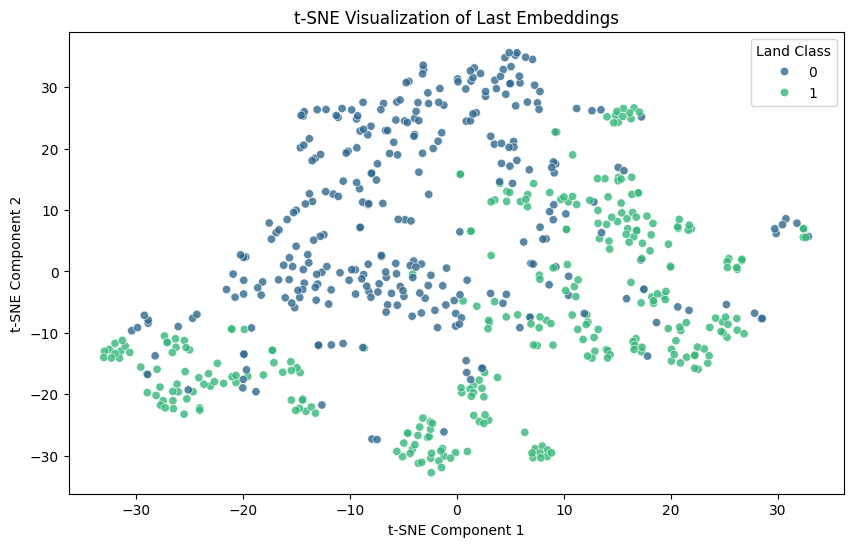

In [20]:
from tensorflow.keras.models import Model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Extract embeddings from the last Dense layer before the output (correct layer name)
embedding_layer = Model(inputs=model.input, outputs=model.get_layer('dense_7').output)

# Get embeddings for X_val
X_embeddings = embedding_layer.predict(X_val)

# Apply t-SNE to reduce embeddings to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_embeddings)

# Plot t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_val, palette='viridis', alpha=0.8)
plt.title("t-SNE Visualization of Last Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Land Class")
plt.show()


##**1DCNN + LSTM**

In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Bidirectional, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef

# Load your dataset
df = sample.iloc[:, 1:-1]  # Replace with actual dataset

# Define features (X) and target (y)
feature_cols = [col for col in df.columns if col != 'land_class']
X = df[feature_cols].values  # Convert features to NumPy array
y = df['land_class'].values  # Binary target

# Convert target variable to binary (ensure it's 0 or 1)
y = np.where(y > 0, 1, 0)  # Modify if necessary based on data

# Train-test split (70% training, 30% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Reshape data to fit 1D CNN + LSTM input format (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# Define Model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))  # (time_steps, features)

# CNN Layers
cnn = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)

cnn = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)

# LSTM Layers
lstm = Bidirectional(LSTM(64, return_sequences=True))(cnn)

# Fully Connected Layers
flatten = Flatten()(lstm)
dense1 = Dense(64, activation='relu')(flatten)
dropout = Dropout(0.3)(dense1)
output = Dense(1, activation='sigmoid')(dropout)  # Binary Classification

# Compile Model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('1DCNNLSTM_model.h5', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr, model_checkpoint], verbose=1)

# Load the best model
model.load_weights('1DCNNLSTM_model.h5')

# Predictions
y_pred_prob = model.predict(X_val)  # Probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert to binary predictions

# Evaluation Metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
mcc = matthews_corrcoef(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print Results
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5934 - loss: 0.6536

45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.5947 - loss: 0.6526 - val_accuracy: 0.5212 - val_loss: 0.6747 - learning_rate: 0.0010
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7725 - loss: 0.4600 - val_accuracy: 0.4984 - val_loss: 0.7036 - learning_rate: 0.0010
Epoch 3/50
43/45 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8107 - loss: 0.4056

45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8123 - loss: 0.4038 - val_accuracy: 0.7010 - val_loss: 0.6321 - learning_rate: 0.0010
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8957 - loss: 0.2809 - val_accuracy: 0.5915 - val_loss: 0.6344 - learning_rate: 0.0010
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.8912 - loss: 0.2751 - val_accuracy: 0.6144 - val_loss: 0.6094 - learning_rate: 0.0010
Epoch 6/50
43/45 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9276 - loss: 0.2001

45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9268 - loss: 0.2012 - val_accuracy: 0.7533 - val_loss: 0.5471 - learning_rate: 0.0010
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9381 - loss: 0.1735 - val_accuracy: 0.6650 - val_loss: 0.5974 - learning_rate: 0.0010
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9312 - loss: 0.1673 - val_accuracy: 0.7320 - val_loss: 0.5256 - learning_rate: 0.0010
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9543 - loss: 0.1424 - val_accuracy: 0.7467 - val_loss: 0.4827 - learning_rate: 0.0010
Epoch 10/50
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9565 - loss: 0.1171

45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9563 - loss: 0.1176 - val_accuracy: 0.8235 - val_loss: 0.4212 - learning_rate: 0.0010
Epoch 11/50
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9589 - loss: 0.1175

45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9588 - loss: 0.1177 - val_accuracy: 0.8660 - val_loss: 0.3411 - learning_rate: 0.0010
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9657 - loss: 0.1036 - val_accuracy: 0.8595 - val_loss: 0.3702 - learning_rate: 0.0010
Epoch 13/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9789 - loss: 0.0766 - val_accuracy: 0.8611 - val_loss: 0.3668 - learning_rate: 0.0010
Epoch 14/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9642 - loss: 0.0884

45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9640 - loss: 0.0887 - val_accuracy: 0.8693 - val_loss: 0.3642 - learning_rate: 0.0010
Epoch 15/50
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9734 - loss: 0.0737

45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9737 - loss: 0.0733 - val_accuracy: 0.8709 - val_loss: 0.3459 - learning_rate: 5.0000e-04
Epoch 16/50
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9831 - loss: 0.0499

45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.9830 - loss: 0.0499 - val_accuracy: 0.8824 - val_loss: 0.3414 - learning_rate: 5.0000e-04
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

Evaluation Metrics:
Accuracy: 0.8824
Precision: 0.8750
Recall: 0.8922
F1-score: 0.8835
MCC: 0.7649

Confusion Matrix:
[[267  39]
 [ 33 273]]


In [23]:
for layer in model.layers:
    print(layer.name)

input_layer_5
conv1d_10
batch_normalization_10
max_pooling1d_10
conv1d_11
batch_normalization_11
max_pooling1d_11
bidirectional_3
flatten_5
dense_11
dropout_5
dense_12


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step


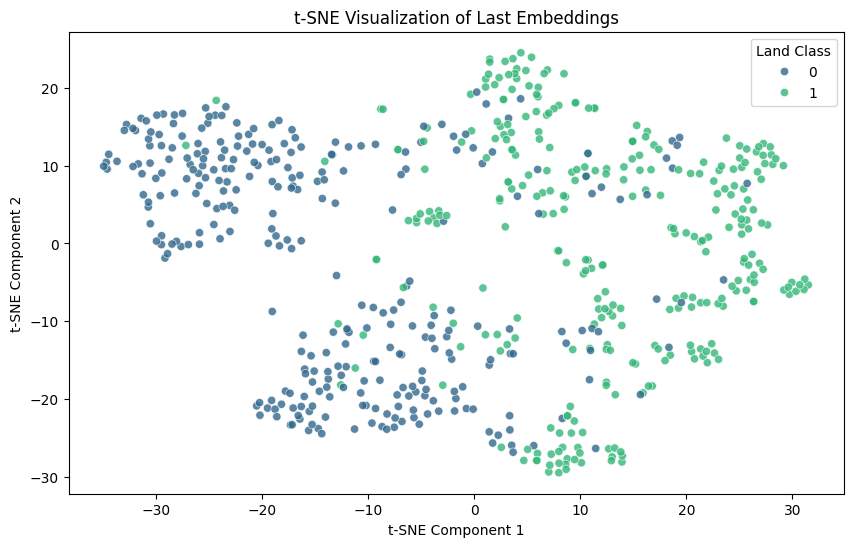

In [24]:
from tensorflow.keras.models import Model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Extract embeddings from the last Dense layer before the output (correct layer name)
embedding_layer = Model(inputs=model.input, outputs=model.get_layer('dense_11').output)

# Get embeddings for X_val
X_embeddings = embedding_layer.predict(X_val)

# Apply t-SNE to reduce embeddings to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_embeddings)

# Plot t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_val, palette='viridis', alpha=0.8)
plt.title("t-SNE Visualization of Last Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Land Class")
plt.show()


##**1DCNN + LSTM Attention**

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization, LSTM, Dense, Dropout, Flatten, Bidirectional, Multiply, Permute, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef

# Load and preprocess data
df = sample.iloc[:, 1:-1]  # Adjust column selection as per your dataset

# Define features (X) and target (y)
feature_cols = [col for col in df.columns if col != 'land_class']
X = df[feature_cols].values  # Convert features to NumPy array
y = df['land_class'].values  # Binary target

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Check shape before reshaping
num_samples, num_features = X.shape
print(f"Original shape of X: {X.shape}")

# Determine the closest valid time_steps
time_steps = 10  # You may adjust this value based on dataset
n_features = num_features // time_steps  # Ensure it divides evenly

if num_features % time_steps != 0:
    print(f"Warning: num_features ({num_features}) is not divisible by time_steps ({time_steps}). Adjusting...")
    n_features = num_features // time_steps  # Reduce to the closest valid value
    X = X[:, :n_features * time_steps]  # Trim excess columns

# Reshape X to (samples, time_steps, features)
X = X.reshape(-1, time_steps, n_features)
print(f"Reshaped X: {X.shape}")

# Convert y to categorical (for binary classification)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the Attention Mechanism
def attention_layer(inputs):
    attention = Dense(inputs.shape[-1], activation='softmax')(inputs)  # Softmax weights
    attention = Multiply()([inputs, attention])  # Apply attention weights
    return attention

# Define Model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))  # (time_steps, features)

# CNN Layers
cnn = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)

cnn = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)

# LSTM Layers
lstm = Bidirectional(LSTM(64, return_sequences=True))(cnn)

# Attention Mechanism
attention = attention_layer(lstm)

# Fully Connected Layers
flatten = Flatten()(attention)
dense1 = Dense(64, activation='relu')(flatten)
dropout = Dropout(0.3)(dense1)
output = Dense(1, activation='sigmoid')(dropout)  # Binary Classification

# Compile Model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('1DCNNLSTM_model_attention.h5', monitor='val_accuracy', save_best_only=True)

# Print Model Summary
model.summary()

# Train Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr, model_checkpoint], verbose=1)

# Load the best model
model.load_weights('1DCNNLSTM_model_attention.h5')

# Evaluate Model
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print Results
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


Original shape of X: (12870, 83)
Reshaped X: (12870, 10, 8)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 10, 8)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 10, 64)         │          1,600 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 10, 64)         │            256 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 5, 64)          │              0 │ batch_normalization[0… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 5, 32)          │          6,176 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 5, 32)          │            128 │ conv1d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 2, 32)          │              0 │ batch_normalization_1… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 2, 128)         │         49,664 │ max_pooling1d_1[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 2, 128)         │         16,512 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 2, 128)         │              0 │ bidirectional[0][0],   │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 256)            │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │         16,448 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             65 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 90,849 (354.88 KB)

 Trainable params: 90,657 (354.13 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
321/322 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6646 - loss: 0.6073

322/322 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.6650 - loss: 0.6069 - val_accuracy: 0.8011 - val_loss: 0.4486 - learning_rate: 0.0010
Epoch 2/50
321/322 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7952 - loss: 0.4372

322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7952 - loss: 0.4371 - val_accuracy: 0.8201 - val_loss: 0.3959 - learning_rate: 0.0010
Epoch 3/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8326 - loss: 0.3731

322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8326 - loss: 0.3731 - val_accuracy: 0.8434 - val_loss: 0.3573 - learning_rate: 0.0010
Epoch 4/50
320/322 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8605 - loss: 0.3114

322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8605 - loss: 0.3115 - val_accuracy: 0.8489 - val_loss: 0.3378 - learning_rate: 0.0010
Epoch 5/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8636 - loss: 0.2997 - val_accuracy: 0.8454 - val_loss: 0.3429 - learning_rate: 0.0010
Epoch 6/50
320/322 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8800 - loss: 0.2729

322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8799 - loss: 0.2729 - val_accuracy: 0.8566 - val_loss: 0.3094 - learning_rate: 0.0010
Epoch 7/50
315/322 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8838 - loss: 0.2578

322/322 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8838 - loss: 0.2579 - val_accuracy: 0.8617 - val_loss: 0.3115 - learning_rate: 0.0010
Epoch 8/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8953 - loss: 0.2357 - val_accuracy: 0.8594 - val_loss: 0.3007 - learning_rate: 0.0010
Epoch 9/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9048 - loss: 0.2151 - val_accuracy: 0.8601 - val_loss: 0.3035 - learning_rate: 0.0010
Epoch 10/50
315/322 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9143 - loss: 0.1996

322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9142 - loss: 0.1999 - val_accuracy: 0.8695 - val_loss: 0.2961 - learning_rate: 0.0010
Epoch 11/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9187 - loss: 0.1855 - val_accuracy: 0.8652 - val_loss: 0.3159 - learning_rate: 0.0010
Epoch 12/50
321/322 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9193 - loss: 0.1858

322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9193 - loss: 0.1858 - val_accuracy: 0.8702 - val_loss: 0.2987 - learning_rate: 0.0010
Epoch 13/50
317/322 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9200 - loss: 0.1700

322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9199 - loss: 0.1701 - val_accuracy: 0.8741 - val_loss: 0.2932 - learning_rate: 0.0010
Epoch 14/50
318/322 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9332 - loss: 0.1579

322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9331 - loss: 0.1581 - val_accuracy: 0.8768 - val_loss: 0.2915 - learning_rate: 0.0010
Epoch 15/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9275 - loss: 0.1659 - val_accuracy: 0.8683 - val_loss: 0.3324 - learning_rate: 0.0010
Epoch 16/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9324 - loss: 0.1455 - val_accuracy: 0.8691 - val_loss: 0.3026 - learning_rate: 0.0010
Epoch 17/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9318 - loss: 0.1533 - val_accuracy: 0.8765 - val_loss: 0.2945 - learning_rate: 0.0010
Epoch 18/50
321/322 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9493 - loss: 0.1210

322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9493 - loss: 0.1210 - val_accuracy: 0.8815 - val_loss: 0.2978 - learning_rate: 5.0000e-04
Epoch 19/50
320/322 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9554 - loss: 0.1058

322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9553 - loss: 0.1058 - val_accuracy: 0.8869 - val_loss: 0.3225 - learning_rate: 5.0000e-04
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Evaluation Metrics:
Accuracy: 0.8869
Precision: 0.8971
Recall: 0.9236
F1-score: 0.9102
MCC: 0.7584

Confusion Matrix:
[[ 809  169]
 [ 122 1474]]


In [6]:
for layer in model.layers:
    print(layer.name)

input_layer
conv1d
batch_normalization
max_pooling1d
conv1d_1
batch_normalization_1
max_pooling1d_1
bidirectional
dense
multiply
flatten
dense_1
dropout
dense_2


✅ Extracts embeddings from the last Dense layer.

✅ Applies t-SNE for dimensionality reduction.

✅ Plots results with colors indicating land classes.

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


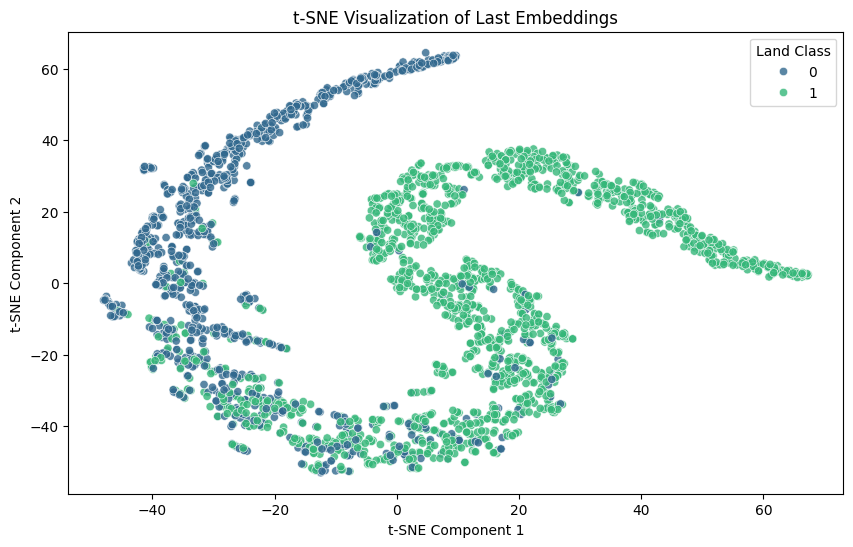

In [7]:
from tensorflow.keras.models import Model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Extract embeddings from the last Dense layer before the output
embedding_layer = Model(inputs=model.input, outputs=model.get_layer('dense_1').output)  # Using 'dense_27'

# Get embeddings for X_test
X_embeddings = embedding_layer.predict(X_test)

# Apply t-SNE to reduce embeddings to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_embeddings)

# Plot t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_test, palette='viridis', alpha=0.8)
plt.title("t-SNE Visualization of Last Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Land Class")
plt.show()


81/81 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step
Explained Variance: PC1 = 82.87%, PC2 = 16.37%


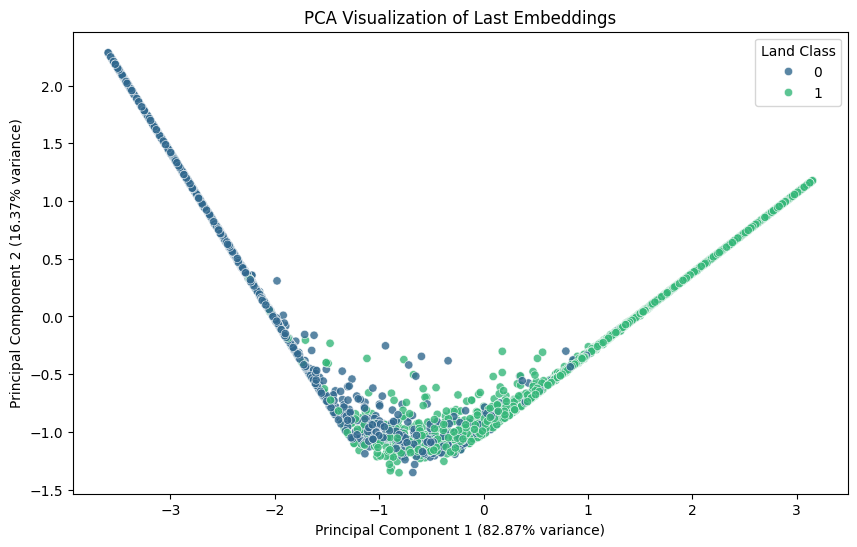

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model

# Extract embeddings from 'dense_27' layer
embedding_layer = Model(inputs=model.input, outputs=model.get_layer('dense_27').output)
X_embeddings = embedding_layer.predict(X_test)

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_embeddings)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance: PC1 = {explained_variance[0]*100:.2f}%, PC2 = {explained_variance[1]*100:.2f}%")

# Plot PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_test, palette='viridis', alpha=0.8)
plt.title("PCA Visualization of Last Embeddings")
plt.xlabel(f"Principal Component 1 ({explained_variance[0]*100:.2f}% variance)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]*100:.2f}% variance)")
plt.legend(title="Land Class")
plt.show()


##**Predicting inference**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import os
os.chdir('/content/drive/MyDrive/GEE_1DCNN_Download')
print(os.getcwd())

/content/drive/MyDrive/GEE_1DCNN_Download


In [9]:
!pip install -r requirement_package_installation.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.8/297.8 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [10]:
%%capture
if 'google.colab' in str(get_ipython()):
  !apt-get install gdal-bin
  !pip install leafmap(raster)

!gdalinfo --version

In [11]:
from google.cloud import storage
client = storage.Client()

In [12]:
!gcloud auth login --no-launch-browser


You are running on a Google Compute Engine virtual machine.
It is recommended that you use service accounts for authentication.

You can run:

  $ gcloud config set account `ACCOUNT`

to switch accounts if necessary.

Your credentials may be visible to others with access to this
virtual machine. Are you sure you want to authenticate with
your personal account?

Do you want to continue (Y/n)?  Y

Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.

In [13]:
# Path to the folder you want to create
folder_path = '/content/landsat'

# Create the folder if it does not exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print("Folder created")
else:
    print("Folder already exists")

Folder created


In [14]:
# Base path for the folders
base_path = '/content/landsat/Images'

# List of folder names to create
folders = ['landsat', 'label', 'COG']
# folders = ['s2']
# Loop through the folder names and create each one
for folder in folders:
    folder_path = os.path.join(base_path, folder)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder '{folder}' created")
    else:
        print(f"Folder '{folder}' already exists")

Folder 'landsat' created
Folder 'label' created
Folder 'COG' created


In [30]:
# !rm -rf /content/landsat/Images/landsat

In [15]:
year = 2020
!python exportsLandsat_100bands.py "projects/ee-akkaraponchaiyana/assets/TTU/grid_centriod_patchsize256_testiles" 2020

Processing 35 samples from the collection: projects/ee-akkaraponchaiyana/assets/TTU/grid_centriod_patchsize256_testiles for the year 2020
Input file size is 256, 256
Input file size is 256, 256
Input file size is 256, 256
0...10...20...30...40...50...60...70...80...90...100 - done.
landsat images: 6 (256, 256, 100)
0...10...20...30...40...50...60...70...80...90...100 - done.
landsat images: 7 (256, 256, 100)
0...10...20...30...40...50...60...70...80...90...100 - done.
landsat images: 0 (256, 256, 100)
Input file size is 256, 256
0...10...20...30...40...50...60...70...80...90...100 - done.
landsat images: 10 (256, 256, 100)
Input file size is 256, 256
Input file size is 256, 256
0...10...20...30...40...50...60...70...80...90...100 - done.
landsat images: 4 (256, 256, 100)
Input file size is 256, 256
Input file size is 256, 256
0...10...20...30...40...50...60...70...80...90...100 - done.
landsat images: 11 (256, 256, 100)
Input file size is 256, 256
Input file size is 256, 256
0...10...2

In [37]:
import os
import glob
import rasterio
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from rasterio.transform import from_origin
from rasterio.shutil import copy as rio_copy

# Load trained model (ensuring input shape is correct)
model_path = "/content/1DCNNLSTM_model_attention.h5"
model = tf.keras.models.load_model(model_path, compile=False)

# Define input and output directories
input_dir = "/content/landsat/Images/landsat"
output_dir = "/content/inference_2020"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# **Ensure preprocessing matches training pipeline**
time_steps = 10  # Must match training
num_features = 80  # Must match original dataset before reshaping
n_features = num_features // time_steps  # Must be exactly 8

if num_features % time_steps != 0:
    raise ValueError(f"Error: num_features ({num_features}) is not divisible by time_steps ({time_steps})")

# **Function to preprocess image exactly like training**
def preprocess_image(filepath, scaler):
    with rasterio.open(filepath) as src:
        image = src.read()  # Read all bands (shape: [bands, height, width])
        transform = src.transform
        crs = src.crs
        profile = src.profile
        height, width = src.height, src.width  # Save dimensions

    # **Flatten image to (num_pixels, num_bands)**
    num_bands, height, width = image.shape
    image_reshaped = image.reshape(num_bands, -1).T  # Shape: (num_pixels, num_bands)
    print(f"Before StandardScaler - Shape: {image_reshaped.shape}")  # Print shape before scaling

    # **Ensure correct number of features (80 features)**
    if image_reshaped.shape[1] > num_features:
        image_reshaped = image_reshaped[:, :num_features]  # Trim extra features
    elif image_reshaped.shape[1] < num_features:
        padding = np.zeros((image_reshaped.shape[0], num_features - image_reshaped.shape[1]))
        image_reshaped = np.hstack([image_reshaped, padding])  # Pad missing features

    # **Standardize using the fitted scaler**
    image_reshaped = scaler.transform(image_reshaped)
    print(f"After StandardScaler - Shape: {image_reshaped.shape}")  # Shape should be (num_pixels, 80)

    # **Reshape into (samples, time_steps, n_features) -> (samples, 10, 8)**
    reshaped_features = image_reshaped.reshape(-1, time_steps, n_features)
    print(f"Final Reshaped Input Shape: {reshaped_features.shape}")  # Should be (samples, 10, 8)

    return reshaped_features, transform, crs, profile, height, width

# **Load and fit StandardScaler using a sample image**
sample_file = glob.glob(os.path.join(input_dir, "*.tif"))[0]
with rasterio.open(sample_file) as sample_src:
    sample_image = sample_src.read().reshape(sample_src.count, -1).T  # Flatten
scaler = StandardScaler()
scaler.fit(sample_image[:, :num_features])  # Fit only first 80 bands

# **Function to convert output to Cloud Optimized GeoTIFF (COG)**
def convert_to_cog(input_tif, output_tif):
    cog_options = {
        "driver": "COG",
        "compress": "DEFLATE",
        "predictor": 2,
        "dtype": "uint8",
    }
    rio_copy(input_tif, output_tif, **cog_options)

# **Process each TIFF file**
tif_files = glob.glob(os.path.join(input_dir, "*.tif"))

for tif_file in tif_files:
    filename = os.path.basename(tif_file)
    output_tif = os.path.join(output_dir, filename)

    try:
        # **Preprocess image using the exact transformation as training**
        image, transform, crs, profile, height, width = preprocess_image(tif_file, scaler)

        # **Run inference**
        prediction = model.predict(image)  # Shape: (samples, 1)
        prediction = prediction.squeeze()  # Remove extra dimensions

        # **Scale probability values from (0-1) to (0-100)**
        pred_scaled = (prediction * 100).astype(np.uint8)  # Convert to 8-bit integer

        # **Reshape prediction to match original raster size (256, 256)**
        pred_reshaped = pred_scaled.reshape(height, width)

        # **Update metadata for output TIFF**
        profile.update(
            dtype=rasterio.uint8,  # Convert to Int8
            count=1,  # Ensure single-band output
            height=height,
            width=width,
            compress="DEFLATE"
        )

        # **Save prediction as GeoTIFF**
        with rasterio.open(output_tif, "w", **profile) as dst:
            dst.write(pred_reshaped, 1)  # Write as single-band

        # **Convert output to Cloud Optimized GeoTIFF**
        convert_to_cog(output_tif, output_tif)

        print(f"Processed: {filename}")

    except Exception as e:
        print(f"Error processing {filename}: {e}")

print("Inference completed and results saved in:", output_dir)


Before StandardScaler - Shape: (65536, 100)
After StandardScaler - Shape: (65536, 80)
Final Reshaped Input Shape: (65536, 10, 8)
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Error processing 00006.tif: /content/inference/00006.tif and /content/inference/00006.tif identify the same dataset.
Before StandardScaler - Shape: (65536, 100)
After StandardScaler - Shape: (65536, 80)
Final Reshaped Input Shape: (65536, 10, 8)
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Error processing 00010.tif: /content/inference/00010.tif and /content/inference/00010.tif identify the same dataset.
Before StandardScaler - Shape: (65536, 100)
After StandardScaler - Shape: (65536, 80)
Final Reshaped Input Shape: (65536, 10, 8)
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Error processing 00029.tif: /content/inference/00029.tif and /content/inference/00029.tif identify the same dataset.
Before StandardScaler - Shape: (65536, 100)
After StandardScaler - Shape: (65536, 80)
Final Reshaped Input Shape: (65536, 10, 8)
2048

In [26]:
def process_in_batches(file_list, batch_size, output_dir):
    """
    Processes TIFF files in batches to create intermediate mosaics.

    Args:
        file_list (list): List of TIFF file paths.
        batch_size (int): Number of files per batch.
        output_dir (str): Directory to save intermediate mosaics.
    """
    batch_files = []
    mosaic_files = []
    batch_count = 0

    # Iterate through files in batches
    for i, file in enumerate(file_list):
        batch_files.append(file)

        # If batch is complete or it's the last batch
        if (i + 1) % batch_size == 0 or (i + 1) == len(file_list):
            batch_count += 1
            print(f"Processing batch {batch_count}")

            # Open files and merge
            src_files = [rasterio.open(f) for f in batch_files]
            mosaic, out_transform = merge(src_files)
            out_meta = src_files[0].meta.copy()
            out_meta.update({
                "driver": "GTiff",
                "height": mosaic.shape[1],
                "width": mosaic.shape[2],
                "transform": out_transform
            })

            # Save intermediate mosaic
            intermediate_path = os.path.join(output_dir, f"intermediate_mosaic_{batch_count}.tif")
            with rasterio.open(intermediate_path, "w", **out_meta) as dest:
                dest.write(mosaic)
            mosaic_files.append(intermediate_path)

            # Close files and reset batch
            for src in src_files:
                src.close()
            batch_files = []

    return mosaic_files


In [27]:
def create_final_mosaic(intermediate_files, output_file):
    """
    Merges intermediate mosaics into the final mosaic.

    Args:
        intermediate_files (list): List of intermediate mosaic file paths.
        output_file (str): Path to save the final mosaic.
    """
    src_files = [rasterio.open(f) for f in intermediate_files]
    mosaic, out_transform = merge(src_files)
    out_meta = src_files[0].meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_transform
    })

    with rasterio.open(output_file, "w", **out_meta) as dest:
        dest.write(mosaic)

    # Close source files
    for src in src_files:
        src.close()


In [40]:
import os
from rasterio.merge import merge
from rasterio.io import MemoryFile

# Define years to process
years = ['2020']

# Define the batch processing and final mosaic creation functions (reuse from previous steps)

for year in years:
    input_dir = f"/content/inference_{year}"
    output_dir = f"/content/mosaic_{year}"
    final_mosaic_path = f"/content/mosaic_{year}/mosaic_{year}.tif"
    batch_size = 1500  # Adjust based on available memory

    # Create output directory if not exists
    os.makedirs(output_dir, exist_ok=True)

    # List all .tif files for the current year
    file_list = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.tif')]

    # Process files in batches
    intermediate_files = process_in_batches(file_list, batch_size, output_dir)

    # Create final mosaic
    create_final_mosaic(intermediate_files, final_mosaic_path)

    print(f"Final mosaic for {year} saved to:", final_mosaic_path)
    !rm -rf /content/mosaic_{year}/intermediate_mosaic_*

Processing batch 1
Final mosaic for 2020 saved to: /content/mosaic_2020/mosaic_2020.tif


In [39]:
!mv /content/inference /content/inference_2020